Section 1: Loading necessary libraries

In [2]:
import pandas as pd
import networkx as nx
from pathlib import Path
from ast import literal_eval
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

Section 2: Load the Cleaned PR Data per Repo

In [3]:
# Output directories
bipartite_dir = Path("../data/networks/bipartite")
projected_dir = Path("../data/networks/projected")

bipartite_dir.mkdir(parents=True, exist_ok=True)
projected_dir.mkdir(parents=True, exist_ok=True)


# Repo paths
repo_files = {
    "scikit-learn": "../data/processed/cleaned/scikit_learn_cleaned.csv",
    "pytorch": "../data/processed/cleaned/pytorch_cleaned.csv",
    "kubernetes": "../data/processed/cleaned/kubernetes_cleaned.csv",
    "apache-spark": "../data/processed/cleaned/apache_spark_cleaned.csv"
}

# Parse contributor lists
def parse_contributors(val):
    try:
        outer = literal_eval(val)
        contributors = []
        for item in outer:
            if isinstance(item, str):
                try:
                    inner = literal_eval(item)
                    if isinstance(inner, list):
                        contributors.extend(inner)
                    else:
                        contributors.append(inner)
                except:
                    contributors.append(item)
            elif isinstance(item, list):
                contributors.extend(item)
            else:
                contributors.append(item)
        return [c for c in contributors if isinstance(c, str) and c.strip() and c != "[]"]
    except:
        return []

Section 3: Create the Bipartite Graphs per Phase

In [4]:

def build_bipartite_and_project(df, repo, phase):
    df_phase = df[df["covid_phase"] == phase]
    print(f"Processing {repo} ({phase}) – {len(df_phase)} rows")

    B = nx.Graph()
    skipped_rows = 0

    for _, row in df_phase.iterrows():
        pr_id = f"{repo}_PR_{row['pr_number']}"
        contributors = row["all_contributors"]
        if not contributors:
            skipped_rows += 1
            continue
        B.add_node(pr_id, bipartite=0)
        for user in contributors:
            if pd.notnull(user):
                B.add_node(user, bipartite=1)
                B.add_edge(user, pr_id)

    print(f"  Bipartite graph has {B.number_of_nodes()} nodes, {B.number_of_edges()} edges. Skipped rows: {skipped_rows}")

    if B.number_of_nodes() == 0:
        print(f"  Skipping {repo} ({phase}) – bipartite graph is empty.")
        return

    # Save bipartite graph
    bipartite_path = bipartite_dir / f"{repo}_{phase}_bipartite.gml"
    nx.write_gml(B, bipartite_path)

    # Project to developer graph
    developers = {n for n, d in B.nodes(data=True) if d["bipartite"] == 1}

    if len(developers) == 0 or len(developers) >= len(B):
        print(f"  Skipping projection – invalid developer set (|developers| = {len(developers)}, |B| = {len(B)})")
        return

    G = bipartite.weighted_projected_graph(B, developers)

    # Threshold edges and remove isolates
    G = nx.Graph(((u, v, d) for u, v, d in G.edges(data=True) if d["weight"] > 1))
    G.remove_nodes_from(list(nx.isolates(G)))

    # Save projected graph
    projected_path = projected_dir / f"{repo}_{phase}_projected.gml"
    nx.write_gml(G, projected_path)

    print(f"  Projected graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")


Section 4: Save Graphs

In [5]:

phases = ["pre", "during", "post"]

for repo, path in repo_files.items():
    df = pd.read_csv(path)
    df["all_contributors"] = df["all_contributors"].apply(parse_contributors)
    df = df.dropna(subset=["covid_phase"])
    print(f"=== {repo.upper()} ===")
    for phase in phases:
        build_bipartite_and_project(df, repo, phase)
    print()


=== SCIKIT-LEARN ===
Processing scikit-learn (pre) – 3436 rows
  Bipartite graph has 3474 nodes, 3249 edges. Skipped rows: 1083
  Projected graph: 95 nodes, 138 edges
Processing scikit-learn (during) – 6211 rows
  Bipartite graph has 5964 nodes, 5673 edges. Skipped rows: 1829
  Projected graph: 131 nodes, 189 edges
Processing scikit-learn (post) – 1085 rows
  Bipartite graph has 1081 nodes, 1089 edges. Skipped rows: 298
  Projected graph: 35 nodes, 52 edges

=== PYTORCH ===
Processing pytorch (pre) – 18264 rows
  Bipartite graph has 14289 nodes, 33882 edges. Skipped rows: 5342
  Projected graph: 359 nodes, 2498 edges
Processing pytorch (during) – 46773 rows
  Bipartite graph has 38398 nodes, 95945 edges. Skipped rows: 11099
  Projected graph: 803 nodes, 8090 edges
Processing pytorch (post) – 10265 rows
  Bipartite graph has 9208 nodes, 30190 edges. Skipped rows: 2074
  Projected graph: 365 nodes, 4539 edges

=== KUBERNETES ===
Processing kubernetes (pre) – 19803 rows
  Bipartite graph 

Section 5: Summary Data

In [6]:
# Paths to projected networks
projected_dir = Path("data/networks/projected")
repos = ["scikit-learn", "pytorch", "kubernetes", "apache-spark"]
phases = ["pre", "during", "post"]

In [7]:
# Collect node/edge counts
summary_data = []

for repo in repos:
    for phase in phases:
        graph_path = projected_dir / f"{repo}_{phase}_projected.gml"
        if graph_path.exists():
            G = nx.read_gml(graph_path)
            summary_data.append({
                "repository": repo,
                "phase": phase,
                "nodes": G.number_of_nodes(),
                "edges": G.number_of_edges()
            })

summary_df = pd.DataFrame(summary_data)
summary_df

""


Section 6: Visualizing the Networks

In [8]:
# Parameters
phases = ["pre", "during", "post"]
repos = ["scikit-learn", "pytorch", "kubernetes", "apache-spark"]
projected_dir = Path("../data/networks/projected")

# Load all graphs
graphs_by_phase = {}
for repo in repos:
    for phase in phases:
        graph_path = projected_dir / f"{repo}_{phase}_projected.gml"
        if graph_path.exists():
            G = nx.read_gml(graph_path)
            key = f"{repo}_{phase}"
            graphs_by_phase[key] = G



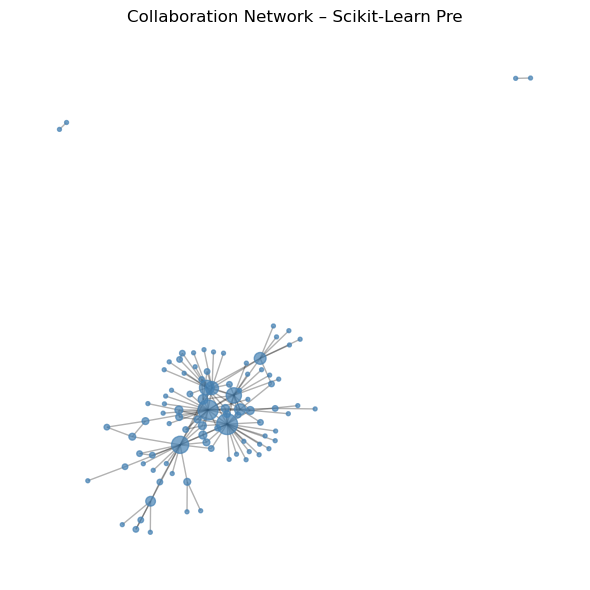

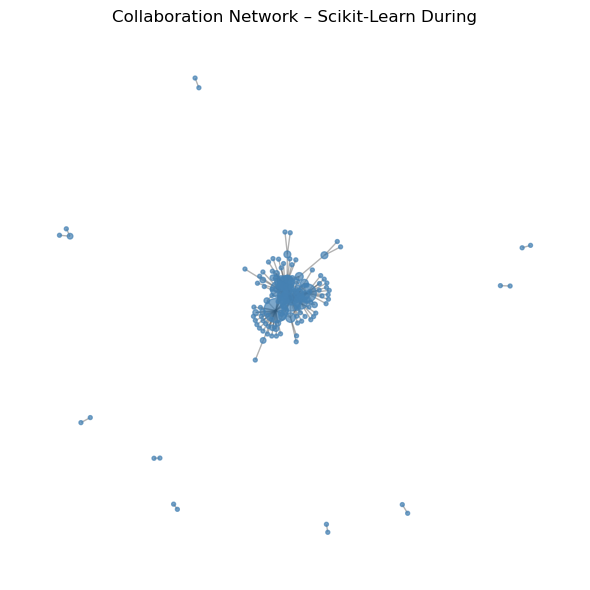

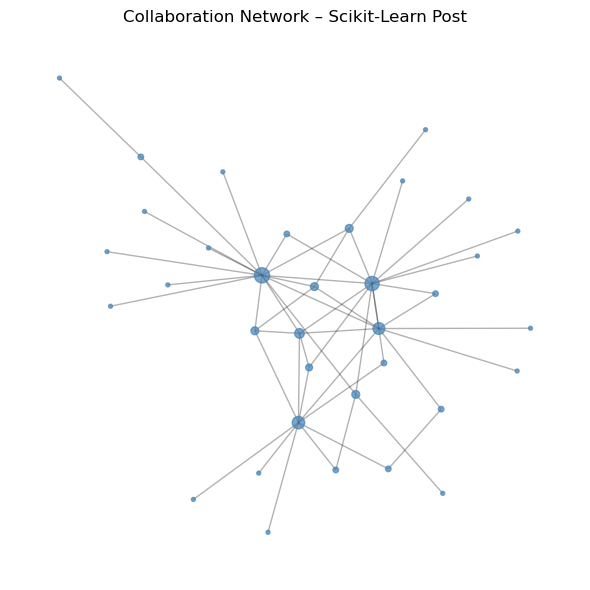

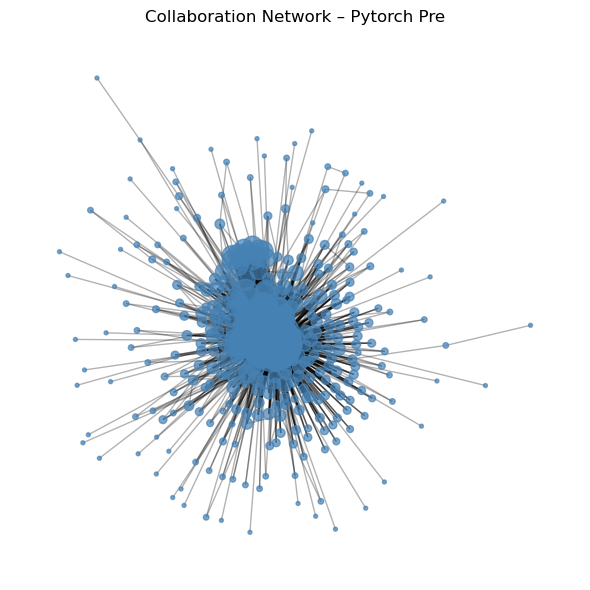

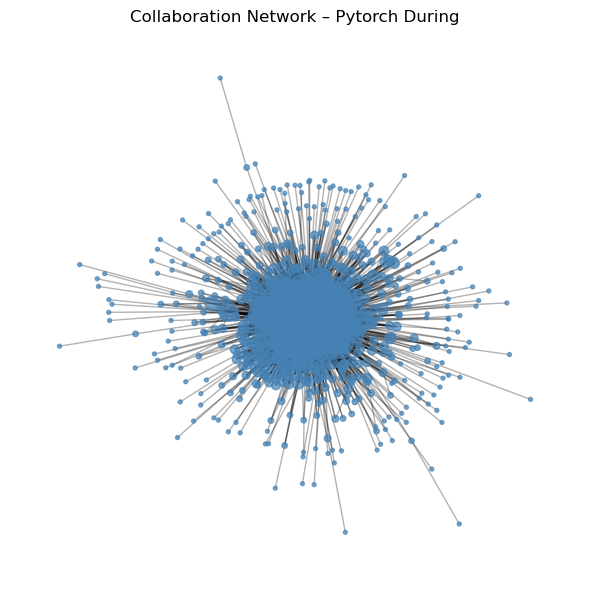

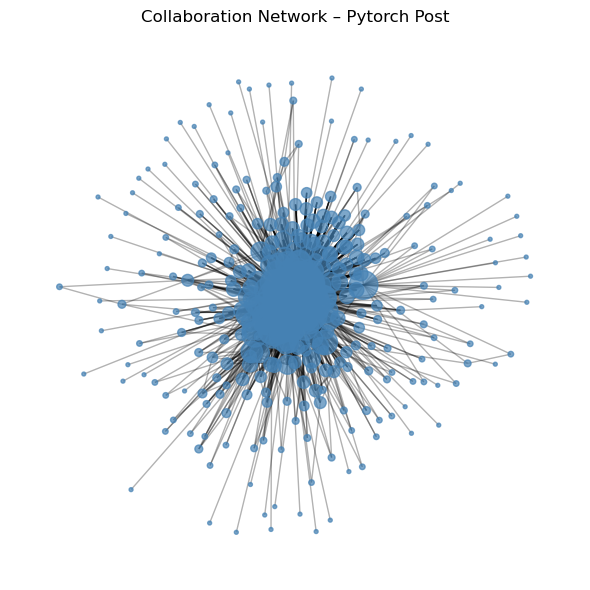

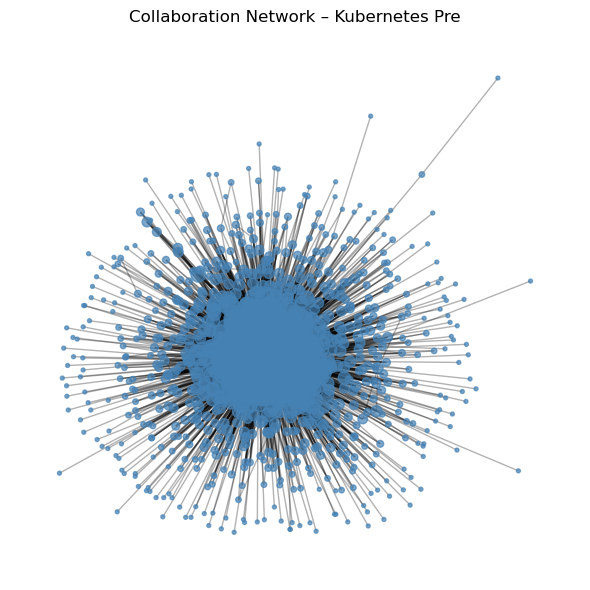

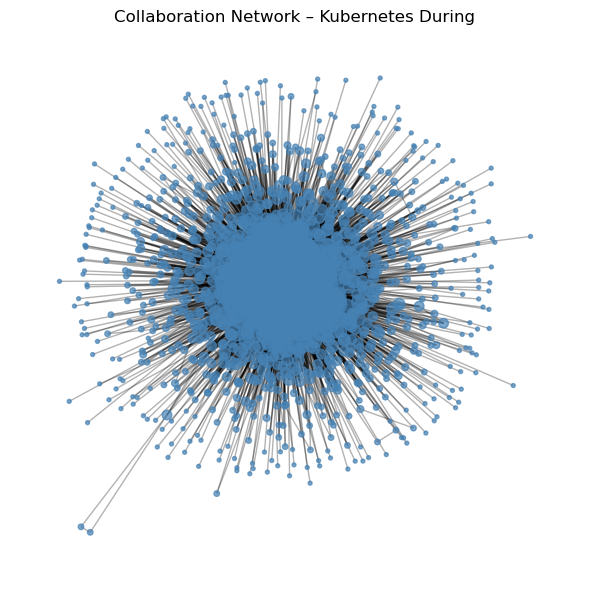

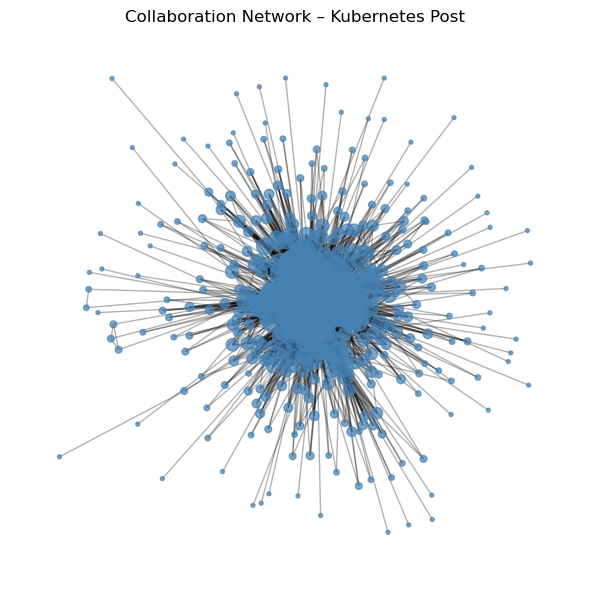

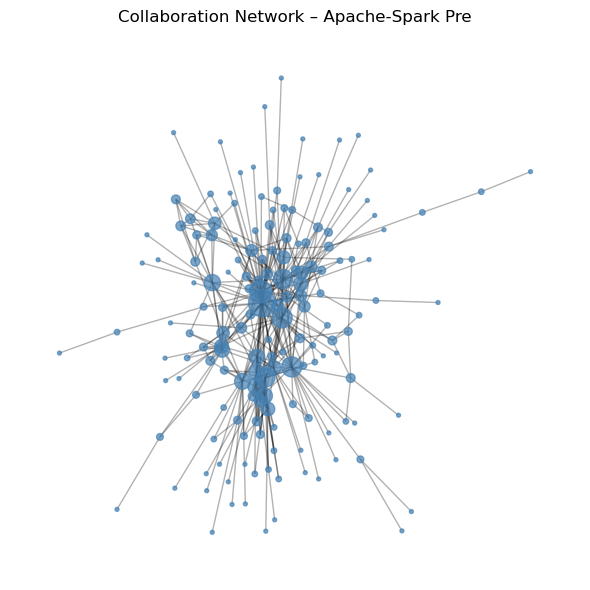

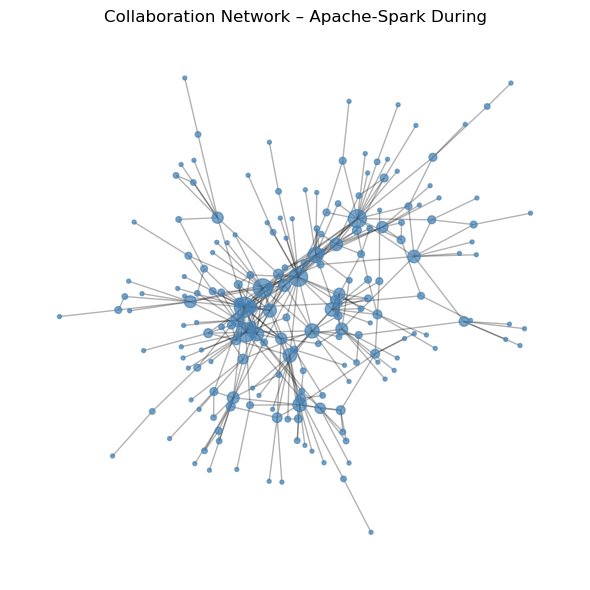

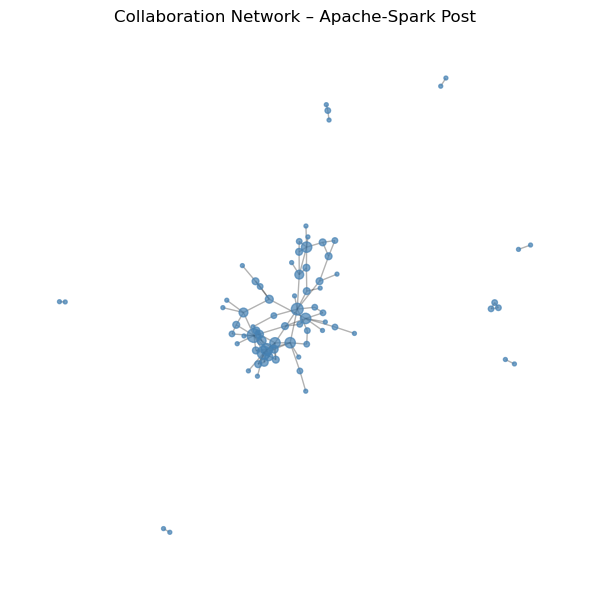

In [11]:
# Visualize one small subgraph per repo per phase
for key, G in graphs_by_phase.items():
    # Use only the largest connected component if too large
    if G.number_of_nodes() > 150:
        largest_cc = max(nx.connected_components(G), key=len)
        G_sub = G.subgraph(largest_cc).copy()
    else:
        G_sub = G

    # Layout and drawing
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(G_sub, seed=42)
    degrees = dict(G_sub.degree)
    node_sizes = [v * 8 for v in degrees.values()]  # Scaled node sizes
    nx.draw_networkx_nodes(G_sub, pos, node_size=node_sizes, alpha=0.7, node_color="steelblue")
    nx.draw_networkx_edges(G_sub, pos, alpha=0.3)
    plt.title(f"Collaboration Network – {key.replace('_', ' ').title()}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

Section 7: Computing Node Strength Across All Projected Graphs

In [ ]:
import networkx as nx
import pandas as pd
from pathlib import Path

# Settings
repos = ["scikit-learn", "pytorch", "kubernetes", "apache-spark"]
phases = ["pre", "during", "post"]
projected_dir = Path("../data/networks/projected")

# Storage for summary
strength_summary = []

# Iterate over all graphs
for repo in repos:
    for phase in phases:
        graph_path = projected_dir / f"{repo}_{phase}_projected.gml"
        if not graph_path.exists():
            print(f"Missing: {graph_path.name} – skipped.")
            continue

        G = nx.read_gml(graph_path)
        if G.number_of_nodes() == 0:
            print(f"Empty graph: {graph_path.name} – skipped.")
            continue

        # Compute node strength
        strength_dict = dict(G.degree(weight="weight"))
        strengths = list(strength_dict.values())

        # Only proceed if strengths are not empty
        if not strengths:
            print(f"No strengths computed for: {graph_path.name} – skipped.")
            continue

        summary = {
            "repository": repo,
            "phase": phase,
            "num_nodes": G.number_of_nodes(),
            "num_edges": G.number_of_edges(),
            "mean_strength": round(pd.Series(strengths).mean(), 2),
            "median_strength": round(pd.Series(strengths).median(), 2),
            "max_strength": round(pd.Series(strengths).max(), 2),
            "std_strength": round(pd.Series(strengths).std(), 2),
        }
        strength_summary.append(summary)

# Convert and sort
strength_df = pd.DataFrame(strength_summary)

if not strength_df.empty:
    strength_df = strength_df.sort_values(by=["repository", "phase"])
    print(strength_df)

else:
    print("No data collected. Please check the input files.")


      repository   phase  num_nodes  num_edges  mean_strength  \
10  apache-spark  during        202        338          11.37   
11  apache-spark    post         76        103           9.37   
9   apache-spark     pre        172        388          20.49   
7     kubernetes  during       1430      18550         211.44   
8     kubernetes    post        423       4072         119.91   
6     kubernetes     pre       1160      18491         262.67   
4        pytorch  during        803       8090         474.11   
5        pytorch    post        365       4539         586.41   
3        pytorch     pre        359       2498         317.14   
1   scikit-learn  during        131        189           9.31   
2   scikit-learn    post         35         52           9.77   
0   scikit-learn     pre         95        138           9.07   

    median_strength  max_strength  std_strength  
10              5.0           119         17.54  
11              6.0            64         11.71  
9   